In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

dataset = np.swapaxes(dataset, 0, 1)
dataset = dataset[:1000, ...]
dataset = np.expand_dims(dataset, axis=-1)

indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 28s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


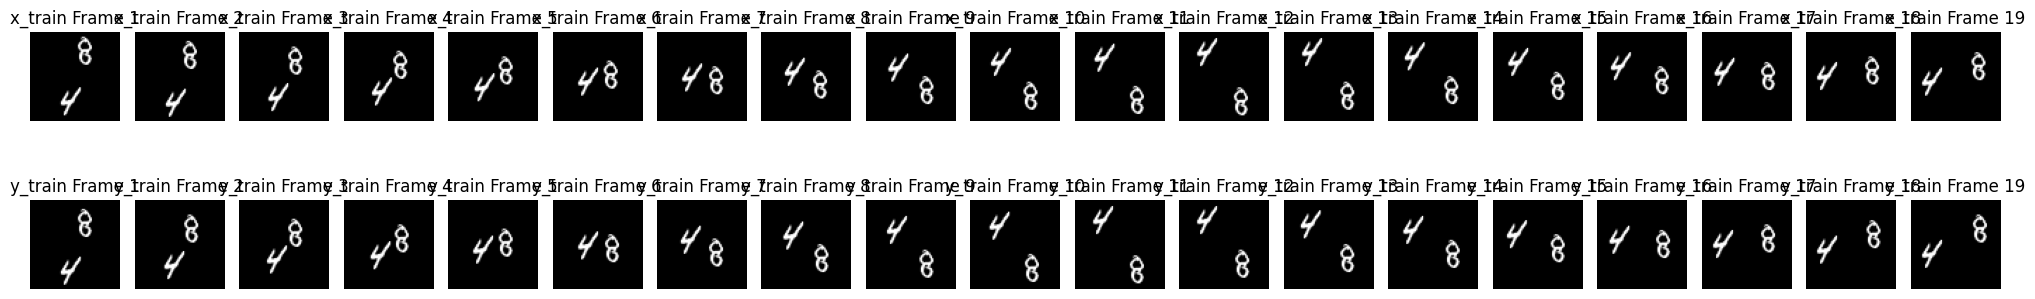

In [17]:
import matplotlib.pyplot as plt

# 첫 번째 시퀀스 샘플 선택
x_sample = x_train[0]
y_sample = y_train[0]

# 프레임 수
num_frames = x_sample.shape[0]

# 시각화
plt.figure(figsize=(20, 4))
for i in range(num_frames):
    # x_train 프레임
    plt.subplot(2, num_frames, i + 1)
    plt.imshow(x_sample[i, :, :, 0], cmap="gray")
    plt.title(f"x_train Frame {i+1}")
    plt.axis("off")

    # y_train 프레임
    plt.subplot(2, num_frames, num_frames + i + 1)
    plt.imshow(y_sample[i, :, :, 0], cmap="gray")
    plt.title(f"y_train Frame {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 데이터 시각화

518 데이터의 프레임별 이미지.
(900, 20, 64, 64, 1)


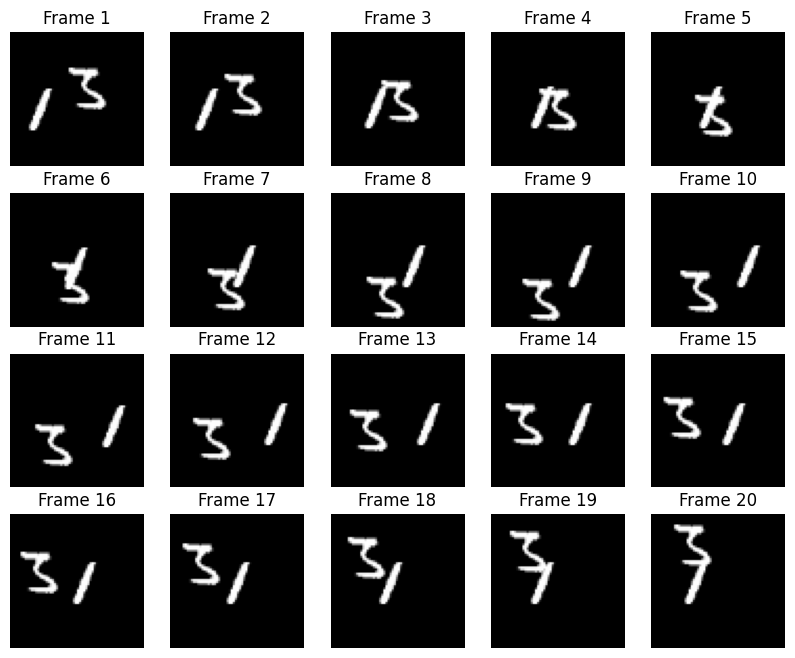

In [16]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"{data_choice} 데이터의 프레임별 이미지.")
print(train_dataset.shape)
plt.show()

## 모델

In [24]:
from tensorflow.keras import layers, models, optimizers, losses

def build_conv3d_model(input_shape):
    inp = layers.Input(shape=input_shape)

    # Conv3D
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Output Conv3D
    x = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)

    model = models.Model(inp, x)
    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam())
    return model

height = 64
width = 64
channels = 1

input_shape = (None, height, width, channels)
model = build_conv3d_model(input_shape)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv3d_13 (Conv3D)          (None, None, 64, 64, 64   1792      
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, None, 64, 64, 64   256       
 tchNormalization)           )                                   
                                                                 
 conv3d_14 (Conv3D)          (None, None, 64, 64, 64   110656    
                             )                                   
                                                                 
 batch_normalization_13 (Ba  (None, None, 64, 64, 64   256 

In [13]:
print(x_train.shape)
print(y_train.shape)

(900, 19, 64, 64, 1)
(900, 19, 64, 64, 1)


## 모델학습

In [25]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 20
batch_size = 5

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 42s 193ms/step - loss: 0.1395 - val_loss: 0.2336 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 35s 192ms/step - loss: 0.0303 - val_loss: 0.9546 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0278 - val_loss: 0.0835 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0268 - val_loss: 0.0356 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0264 - val_loss: 0.0265 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0265 - val_loss: 0.0258 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0260 - val_loss: 0.0255 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0255 - val_loss: 0.0258 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 34s 191ms/step - l

1/1 [==============================] - 0s 177ms/step


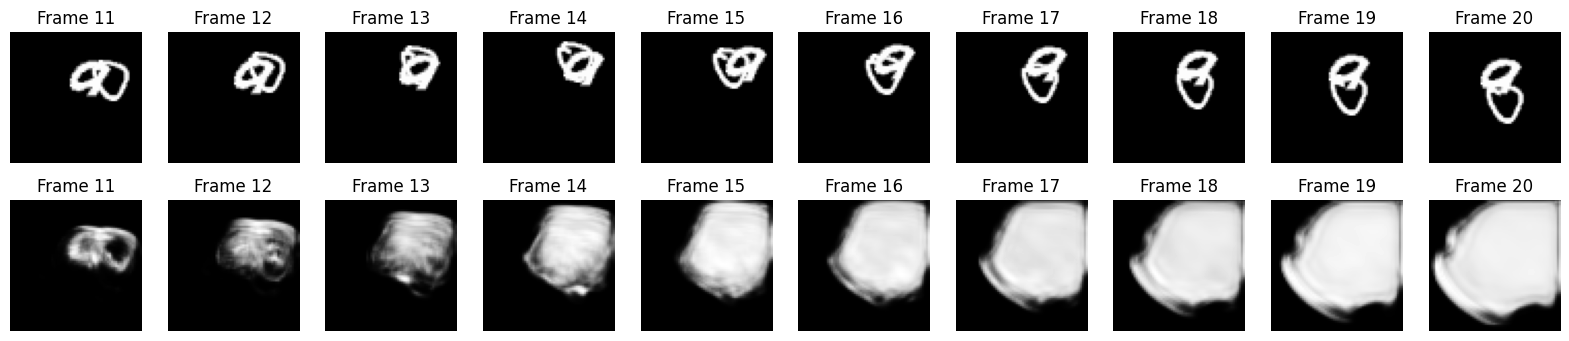

In [26]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

In [27]:
# examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# predicted_videos = []
# for example in examples:
#     frames = example[:10, ...]
#     original_frames = example[10:, ...]
#     new_predictions = np.zeros(shape=(10, *frames[0].shape))

#     for i in range(10):
#         frames = example[: 10 + i + 1, ...]
#         new_prediction = model.predict(np.expand_dims(frames, axis=0))
#         new_prediction = np.squeeze(new_prediction, axis=0)
#         predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#         new_predictions[i] = predicted_frame

#     for frame_set in [original_frames, new_predictions]:
#         current_frames = np.squeeze(frame_set)
#         current_frames = current_frames[..., np.newaxis] * np.ones(3)
#         current_frames = (current_frames * 255).astype(np.uint8)
#         current_frames = list(current_frames)

#         with io.BytesIO() as gif:
#             imageio.mimsave(gif, current_frames, "GIF", duration=200)
#             predicted_videos.append(gif.getvalue())

# print(" Truth\tPrediction")
# for i in range(0, len(predicted_videos), 2):
#     box = HBox(
#         [
#             widgets.Image(value=predicted_videos[i]),
#             widgets.Image(value=predicted_videos[i + 1]),
#         ]
#     )
#     display(box)

from IPython.display import HTML, display
import io
import imageio
import ipywidgets as widgets
from IPython.display import display, Image
from ipywidgets import HBox

# 예측된 비디오들을 저장할 리스트
predicted_videos = []

# 예제로 선택할 데이터
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# 예제별로 예측 프레임 생성 및 GIF로 변환
for example in examples:
    frames = example[:10, ...]  # 처음 10프레임
    original_frames = example[10:, ...]  # 실제 프레임

    new_predictions = np.zeros(shape=(10, *frames[0].shape))  # 예측 프레임 초기화

    # 예측 프레임 생성
    for i in range(10):
        frames = example[: 10 + i + 1, ...]  # 현재까지의 프레임
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    # 원본 프레임과 예측 프레임을 GIF로 변환
    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# HTML을 사용하여 GIF를 반복 재생하도록 표시
def display_gif_in_loop(gif_bytes):
    html_str = f"<img src='data:image/gif;base64,{gif_bytes.decode('ascii')}' loop='true' />"
    display(HTML(html_str))

print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox([
        widgets.Image(value=predicted_videos[i]),
        widgets.Image(value=predicted_videos[i + 1]),
    ])
    display(box)


1/1 [==============================] - 0s 18ms/step
Truth	Prediction
